In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [3]:
def build_encoder(embedding_dim=64):
    inp = keras.Input(shape=(None, 3))  # variable-length sequence of (x,y,z)

    x = layers.Masking(mask_value=0.0)(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(128, activation="relu")(x) 
    out = layers.Dense(embedding_dim)(x)   # final embed

    return keras.Model(inp, out, name="gesture_encoder")

encoder = build_encoder()
encoder.summary()

Model: "gesture_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 3)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, None, 3)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │     34,816 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,608 (361.75 KB)

 Trainable params: 92,608 (361.75 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
gest1 = keras.Input(shape=(None, 3))
gest2 = keras.Input(shape=(None, 3))

enc1 = encoder(gest1)
enc2 = encoder(gest2)

# L2 distance
distance = layers.Lambda(lambda x: tf.norm(x[0] - x[1], axis=1, keepdims=True))([enc1, enc2])

siamese = keras.Model([gest1, gest2], distance, name="siamese_network")
siamese.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gesture_encoder     │ (None, 64)        │     92,608 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ gesture_encoder[… │
│                     │                   │            │ gesture_encoder[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,608 (361.75 KB)

 Trainable params: 92,608 (361.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    # y_true: 0 = same gesture, 1 = different
    # y_pred: distance between embeddings
    return tf.reduce_mean(
        (1 - y_true) * tf.square(y_pred) +
        (y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    )

In [6]:
siamese.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=contrastive_loss
)

In [1]:
import numpy as np

data = np.load('gesture_dataset.npz', allow_pickle=True)  # must allow pickle for object arrays
X = data['X']  # gestures
y = data['y']  # labels
class_to_label = data['class_to_label'].item()  # convert from 0-d object to dict


In [4]:
print("Keys in the file:", data.files)
print("Number of gestures:", len(X))
print("Number of labels:", len(y))
print("Class mapping:", class_to_label)
X.shape

Keys in the file: ['X', 'y', 'class_to_label']
Number of gestures: 60
Number of labels: 60
Class mapping: {'checkmark': 0, 'circle': 1, 'line': 2, 'square': 3}


(60,)

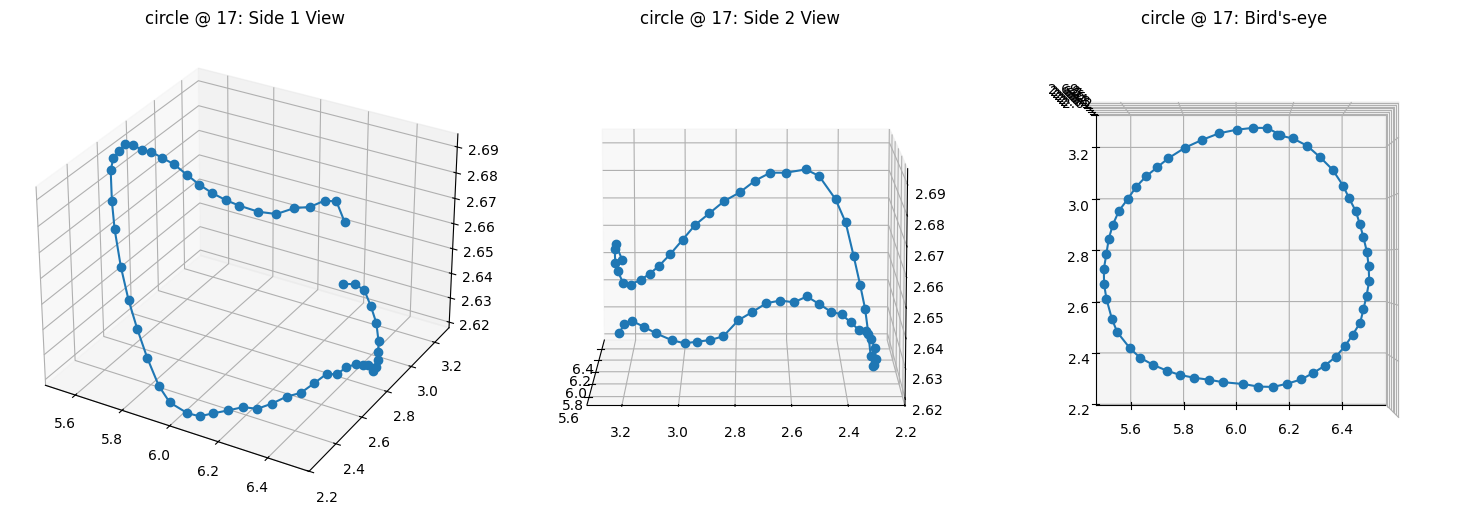

In [16]:
import matplotlib.pyplot as plt
gesture_index = 17  # input idx to show here, each idx is a gesture
gesture = X[gesture_index]
xs, ys, zs = zip(*gesture)

fig = plt.figure(figsize=(15, 5))


label = y[gesture_index]
class_name = [k for k,v in class_to_label.items() if v == label][0]


# --- Default angle ---
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(xs, ys, zs, marker='o')
ax1.set_title(f"{class_name} @ {gesture_index}: Side 1 View")

# --- Behind view ---
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(xs, ys, zs, marker='o')
ax2.view_init(elev=10, azim=180)  # adjust elevation and azimuth
ax2.set_title(f"{class_name} @ {gesture_index}: Side 2 View")

# --- Bird's-eye view ---
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(xs, ys, zs, marker='o')
ax3.view_init(elev=90, azim=-90)  # look straight down
ax3.set_title(f"{class_name} @ {gesture_index}: Bird's-eye")

plt.tight_layout()
plt.show()

In [ ]:

print(f"Gesture at index {gesture_index} is a '{class_name}' gesture")

Gesture at index 50 is a 'square' gesture
